## **Exploratory data analysis**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("data/01_mao_a_bioactivity_data_labelled.csv")

### **Distribution of active(1) and inactive(0)**

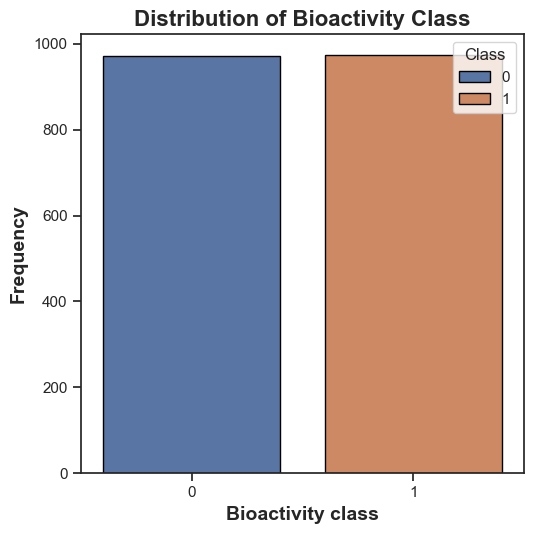

In [6]:
plt.figure(figsize=(5.5, 5.5))

# Assume there's a column named 'Target_Type' you want to use as hue
ax = sns.countplot(data=df, x='Class', hue='Class', edgecolor='black')

ax.set_xlabel('Bioactivity class', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Bioactivity Class', fontsize=16, fontweight='bold')

plt.legend(title='Class')
plt.tight_layout()
plt.savefig('plots/plot_bioactivity_class.png', dpi=600)
plt.show()

### **Lipinski descriptors**

In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski

# Function to standardize SMILES and compute Lipinski descriptors
def process_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid SMILES

    # Optionally: Kekulize, sanitize, or canonicalize
    Chem.SanitizeMol(mol)

    # Lipinski descriptors
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    rot_bonds = Lipinski.NumRotatableBonds(mol)
    tpsa = Descriptors.TPSA(mol)
    return [mw, logp, hbd, hba, rot_bonds, tpsa]

# Apply to your filtered dataframe
lipinski_data = df['standardized_smiles'].apply(process_smiles)

# Drop rows with invalid SMILES
valid_idx = lipinski_data.notnull()
df = df[valid_idx].reset_index(drop=True)
lipinski_df = pd.DataFrame(lipinski_data[valid_idx].tolist(),
                           columns=["MW", "LogP", "HBD", "HBA", "RotBonds", "TPSA"])

# Merge descriptors with class labels
df_lipinski = pd.concat([df[['molecule_chembl_id', 'standardized_smiles', 'Class', 'pIC50']], lipinski_df], axis=1)

# Display
df_lipinski.head()

,molecule_chembl_id,standardized_smiles,Class,pIC50,MW,LogP,HBD,HBA,RotBonds,TPSA
0,CHEMBL155754,C/N=C1/CCc2c1n(C)c1ccc(OC(=O)NC)c(Cl)c21,1,5.866461,305.765,2.9150,1,4,1,55.62
1,CHEMBL160347,COc1cc(Br)c2oc(C3CCNCC3)cc2c1,1,6.744727,310.191,3.6709,1,3,2,34.40
2,CHEMBL347197,CC/N=C1/CCc2c1n(C)c1ccccc21,1,5.673664,212.296,2.9335,0,2,1,17.29
3,CHEMBL348607,CCCCNC(=O)Oc1ccc2c(c1Br)c1c(n2C)/C(=N\C)CC1,1,6.124939,392.297,4.1944,1,4,4,55.62
4,CHEMBL156919,CCC/N=C1/CCc2c1n(C)c1ccccc21,1,5.793174,226.323,3.3236,0,2,2,17.29


In [9]:
df_lipinski.to_csv("data/02_mao_a_bioactivity_data_lipinski.csv", index=None)

**MW vs LogP distribution**

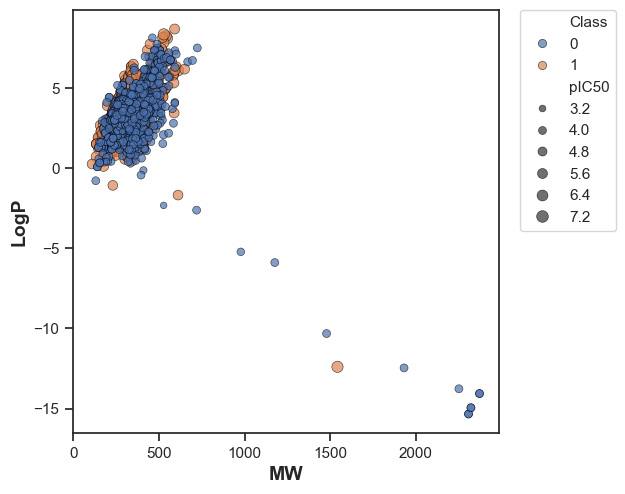

In [10]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_lipinski, hue='Class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plots/plot_MW_vs_LogP.png', dpi=600)

**Mann-Whitney test**

In [13]:
def mannwhitney(descriptor, verbose=False):
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'Class']
  df = df_lipinski[selection]
  active = df[df['Class'] == 1]
  active = active[descriptor]

  selection = [descriptor, 'Class']
  df = df_lipinski[selection]
  inactive = df[df['Class'] == 0]
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

**Boxplot of pIC50**

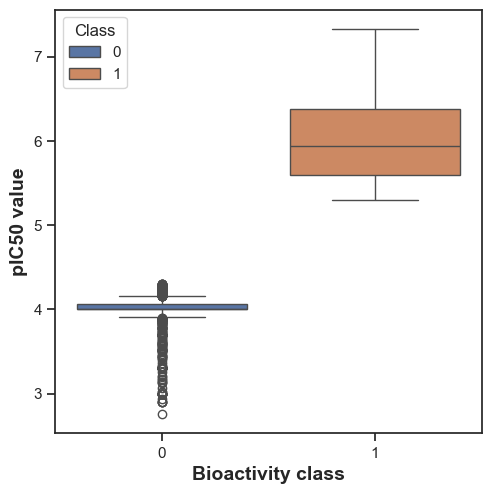

In [11]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'pIC50', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_pIc50.png', dpi=600)

In [14]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,945756.0,0.0,0.05,Different distribution (reject H0)


**Boxplot of MW**

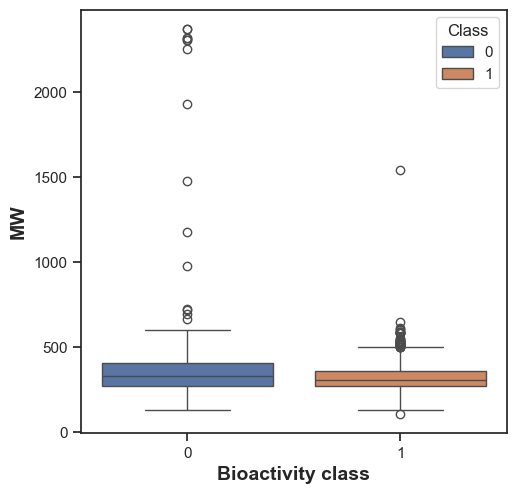

In [15]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'MW', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_MW.png', dpi=600)

In [16]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,415221.5,0.000003,0.05,Different distribution (reject H0)


**Boxplot of LogP**

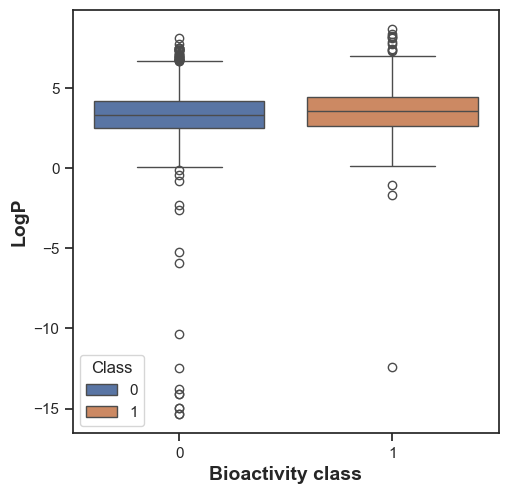

In [17]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'LogP', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_LogP.png', dpi=600)

In [18]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,521860.5,0.000076,0.05,Different distribution (reject H0)
